In [530]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_predict, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import ComplementNB, MultinomialNB
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn import svm
import seaborn as sns
import scikitplot as skplt
import joblib
from scipy.stats import uniform as sp_rand
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
import plotly_express as px

In [486]:
cnb = joblib.load('../models/cnb.pkl')

In [487]:
df = pd.read_csv('../data/The-Office-Lines-V3.csv', encoding='latin-1')

In [488]:
df['line'] = df['line'].str.lower()
speakers = []
for i in df.speaker.value_counts().head(22).index:
    speakers.append(i)

In [489]:
speakers

['Michael',
 'Dwight',
 'Jim',
 'Pam',
 'Andy',
 'Kevin',
 'Angela',
 'Erin',
 'Oscar',
 'Ryan',
 'Darryl',
 'Phyllis',
 'Kelly',
 'Toby',
 'Jan',
 'Stanley',
 'Meredith',
 'Holly',
 'Nellie',
 'Gabe',
 'Robert',
 'Creed']

In [490]:
speaker_extras = ["'", 'and', '&', '/', 'as', ',']

In [491]:
df = df[df.speaker.str.match('|'.join(speakers))]
df.drop(df[df.speaker.str.contains('|'.join(speaker_extras))].index, inplace=True)

In [492]:
df['speaker'] = df.speaker.str.replace(': ','')
df['speaker'] = df.speaker.str.replace(':','')
df['speaker'] = df.speaker.str.replace('.','')
df['speaker'] = df.speaker.str.replace('Dwight ','Dwight')
df['speaker'] = df.speaker.str.replace('Michael ','Michael')
df['speaker'] = df.speaker.str.replace('DwightKSchrute','Dwight')
df['speaker'] = df.speaker.str.replace('Jim ','Jim')
df['speaker'] = df.speaker.str.replace('Pam ','Pam')
df['speaker'] = df.speaker.str.replace('Robert California','Robert')
df['speaker'] = df.speaker.str.replace('Nellie Bertram','Nellie')

In [493]:
df.drop(df[df.speaker=='Ryan Howard'].index, inplace=True)
df.drop(df[df.speaker=='Robert Dunder'].index, inplace=True)
df.drop(df[df.speaker=='Gabe'].index, inplace=True)
df.drop(df[df.speaker=='Holly'].index, inplace=True)
df.drop(df[df.speaker=='Kelly'].index, inplace=True)
df.drop(df[df.speaker=='Meredith'].index, inplace=True)
df.drop(df[df.speaker=='Nellie'].index, inplace=True)
df.drop(df[df.speaker=='Oscar'].index, inplace=True)
df.drop(df[df.speaker=='Phyllis'].index, inplace=True)
df.drop(df[df.speaker=='Toby'].index, inplace=True)
df.drop(df[df.speaker=='Jan'].index, inplace=True)
df.drop(df[df.speaker=='Erin'].index, inplace=True)
df.drop(df[df.speaker=='Robert'].index, inplace=True)
df.drop(df[df.speaker=='Ryan'].index, inplace=True)
df.drop(df[df.speaker=='Creed'].index, inplace=True)
df.drop(df[df.speaker=='Kevin'].index, inplace=True)
df.drop(df[df.speaker=='Darryl'].index, inplace=True)

In [494]:
len(df.speaker.unique())

7

In [495]:
X = df.line
y = df.speaker

In [496]:
# from nltk.corpus import stopwords
# import re
# from nltk.stem import PorterStemmer

In [497]:
# ps = PorterStemmer()

In [498]:
# stopword = set(stopwords.words('english'))

In [499]:
# X = [re.sub('[^a-zA-Z]',' ',doc) for doc in X ] #  include only characters and replace other characters with space

In [500]:
# X = [doc.split() for doc in X ] # split into words

In [501]:
# def convert(words) :
  
#     current_words = list()
#     for i in words :
#         if i.lower() not in stopword :
            
#             updated_word = ps.stem(i)
#             current_words.append(updated_word.lower())
#     return current_words

In [502]:
# X = [ convert(doc)   for doc in X ] # update the documetns

In [503]:
# X = [ " ".join(doc) for doc in X]

In [504]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [505]:
count_vect = CountVectorizer(stop_words='english', decode_error='replace')
X_train_counts = count_vect.fit_transform(X_train)

In [506]:
# joblib.dump(count_vect.vocabulary_, '../models/searchcountVec.pkl')

In [507]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [508]:
X_test_counts = count_vect.transform(X_test)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

In [509]:
print(X_test_counts.shape)
print(X_test_tfidf.shape)

(6973, 13831)
(6973, 13831)


In [510]:
param_grid = {'alpha': sp_rand()}

In [511]:
rsearch = RandomizedSearchCV(estimator=cnb, param_distributions=param_grid, n_iter=1000)
search = rsearch.fit(X_train_tfidf, y_train)

In [512]:
# joblib.dump(search, '../models/search.pkl')

In [513]:
print(search.best_score_)
print(search.best_estimator_.alpha)

0.32182244303214047
0.9976886673199656


In [514]:
pred = search.predict(X_test_tfidf)

In [515]:
print(metrics.classification_report(y_test, pred))

              precision    recall  f1-score   support

        Andy       0.20      0.24      0.22       747
      Angela       0.23      0.12      0.16       310
      Dwight       0.37      0.28      0.32      1359
         Jim       0.30      0.29      0.30      1252
     Michael       0.40      0.51      0.45      2170
         Pam       0.26      0.22      0.24      1001
     Stanley       0.07      0.03      0.04       134

    accuracy                           0.33      6973
   macro avg       0.26      0.24      0.25      6973
weighted avg       0.32      0.33      0.32      6973



In [516]:
conf_mx = confusion_matrix(y_test, pred)
conf_mx

array([[ 182,   14,  100,  100,  258,   88,    5],
       [  41,   37,   47,   47,   97,   36,    5],
       [ 159,   26,  384,  178,  457,  144,   11],
       [ 143,   13,  130,  367,  431,  164,    4],
       [ 248,   45,  275,  293, 1102,  184,   23],
       [ 106,   27,   85,  222,  329,  224,    8],
       [  16,    2,   23,   20,   55,   14,    4]])

In [517]:
row_sums = conf_mx.sum(axis=1, keepdims=True) 
norm_conf_mx = conf_mx / row_sums

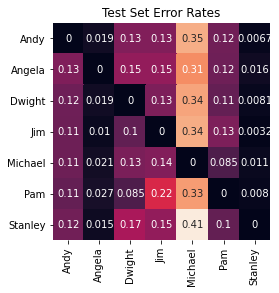

In [532]:
np.fill_diagonal(norm_conf_mx, 0) 
sns.heatmap(norm_conf_mx, square=True, annot=True, cbar=False,
           xticklabels=search.classes_, yticklabels=search.classes_)
plt.title('Test Set Error Rates');

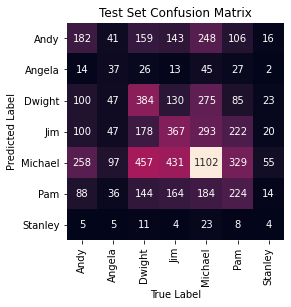

In [533]:
mat = confusion_matrix(y_test, pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
           xticklabels=search.classes_, yticklabels=search.classes_)
plt.xlabel('True Label')
plt.ylabel('Predicted Label')
plt.title('Test Set Confusion Matrix');

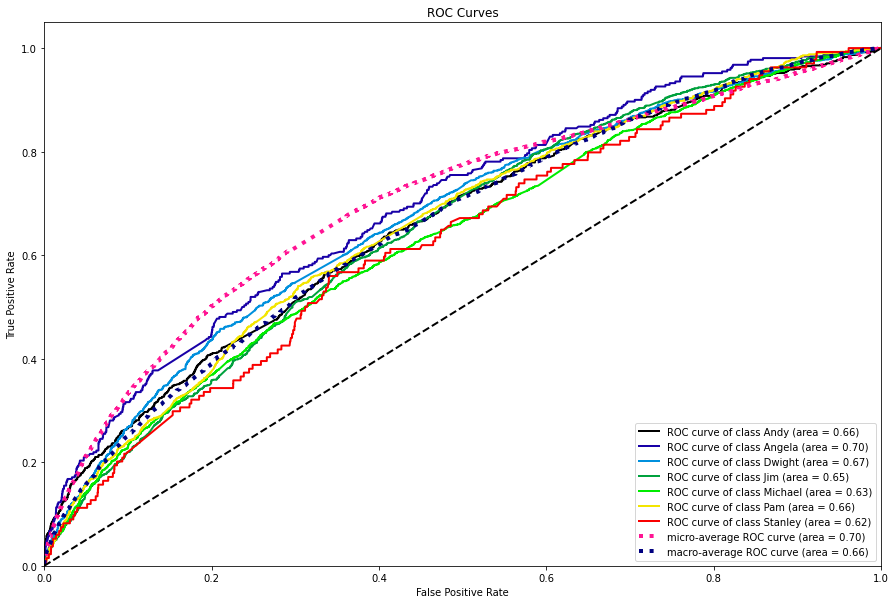

In [534]:
y_true = y_test
y_probas = search.predict_proba(X_test_tfidf)
skplt.metrics.plot_roc(y_true, y_probas, figsize=(15, 10))
plt.show()

In [535]:
text = ["you miss 100% of the shots you don't take"]

In [536]:
text_counts = count_vect.transform(text)
text_tfidf = tfidf_transformer.transform(text_counts)
search.predict(text_tfidf)

array(['Angela'], dtype='<U7')

In [537]:
spec = norm_conf_mx.sum(axis=0)/(len(search.classes_)-1)
spec_speakers = search.classes_

In [538]:
spec_df = pd.DataFrame(spec, index=spec_speakers).reset_index()
spec_df.rename({'index':'Character', 0:'Error Rate'}, axis=1, inplace=True)
spec_df = spec_df.round(2)
spec_df.sort_values(by='Error Rate', inplace=True)

In [539]:
fig = px.bar(spec_df, x = 'Character', y = 'Error Rate', orientation = 'v', 
             title = '<b>Error Rates</b>',
            color_continuous_scale=px.colors.sequential.Redor,color = 'Error Rate',text = 'Error Rate')
fig.show()

In [416]:
y.unique()

array(['Michael', 'Jim', 'Pam', 'Dwight', 'Stanley', 'Angela', 'Andy'],
      dtype=object)

In [30]:
X.values

array(['all right jim. your quarterlies look very good. how are things at the library?',
       "oh, i told you. i couldn't close it. so...",
       "so you've come to the master for guidance? is this what you're saying, grasshopper?",
       ...,
       'everyday when i came into work, all i wanted to do was leave. so why in the world does it feel so hard to leave right now?',
       "i sold paper at this company for 12 years. my job was to speak to clients on the phone about quantities and types of copier paper. even if i didn't love every minute of it, everything i have, i owe to this job. this stupid...wonderful...boring...amazing job.",
       "i thought it was weird when you picked us to make a documentary. but all in all...i think an ordinary paper company like dunder mifflin was a great subject for a documentary. there's a lot of beauty in ordinary things. isn't that kind of the point?"],
      dtype=object)

1.0

In [41]:
vec = TfidfVectorizer(stop_words="english")
vec.fit(X.values)
features = vec.transform(X.values)

In [42]:
cls = KMeans(n_clusters=len(df.speaker.unique()))
cls.fit(features)

KMeans(n_clusters=9)

In [43]:
features.shape

(37573, 16047)

In [55]:
lsa = TruncatedSVD(n_components=100)
reduced_features = lsa.fit_transform(features.toarray())

In [51]:
reduced_cluster_centers = lsa.transform(cls.cluster_centers_)

In [423]:
tsne = TSNE(n_components=2, perplexity=40)
reduced_features = tsne.fit_transform(reduced_features)

# reduced_cluster_centers = tsne.transform(cls.cluster_centers_)

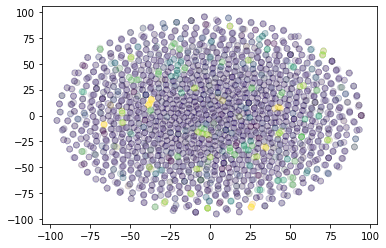

In [440]:
fig, ax = plt.subplots()
ax.scatter(reduced_features[:,0], reduced_features[:,1], c=cls.predict(features), alpha=.01)
# ax.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='r')

In [427]:
tsne = TSNE(n_components=2, perplexity=30)
reduced_features = tsne.fit_transform(reduced_features)

# reduced_cluster_centers = tsne.transform(cls.cluster_centers_)

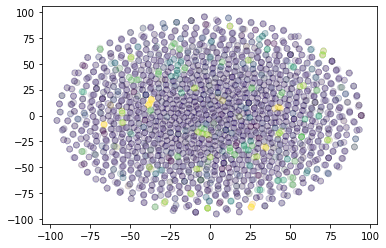

In [428]:
fig, ax = plt.subplots()
ax.scatter(reduced_features[:,0], reduced_features[:,1], c=cls.predict(features), alpha=.01)
# ax.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='r')

In [48]:
# pca = PCA(n_components=50)
# reduced_features = pca.fit_transform(features.toarray())

# reduced_cluster_centers = pca.transform(cls.cluster_centers_)

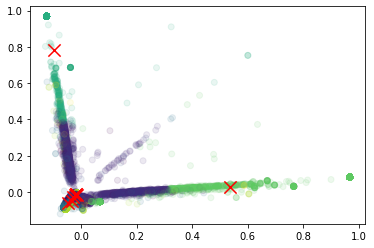

In [46]:
# fig, ax = plt.subplots()
# ax.scatter(reduced_features[:,0], reduced_features[:,1], c=cls.predict(features), alpha=.1)
# ax.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='r')

In [17]:
# tsne = TSNE(n_components=2)
# reduced_features = tsne.fit_transform(reduced_features)

# reduced_cluster_centers = tsne.transform(cls.cluster_centers_)

In [18]:
# fig, ax = plt.subplots()
# ax.scatter(reduced_features[:,0], reduced_features[:,1], c=cls.predict(features))
# ax.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='r')

In [17]:
tsne = TSNE(n_components=3)
reduced_features = tsne.fit_transform(reduced_features)

# reduced_cluster_centers = tsne.transform(cls.cluster_centers_)

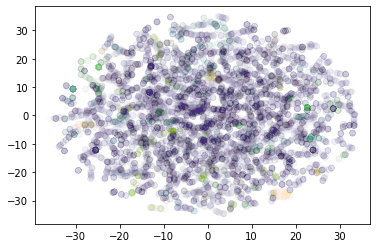

In [63]:
fig, ax = plt.subplots()
ax.scatter(reduced_features[:,0], reduced_features[:,1], c=cls.predict(features), alpha=.009)
# ax.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='r')

In [ ]:
# from sklearn.decomposition import NMF
# nmf = NMF(n_components=9)
# nmf.fit(features)

In [78]:
# feature_names = vec.get_feature_names()

# n_top_words = 10

# for i, topic_vec in enumerate(nmf.components_):
#     print(i, end=' ')
#     # topic_vec.argsort() produces a new array
#     # in which word_index with the least score is the
#     # first array element and word_index with highest
#     # score is the last array element. Then using a
#     # fancy indexing [-1: -n_top_words-1:-1], we are
#     # slicing the array from its end in such a way that
#     # top `n_top_words` word_index with highest scores
#     # are returned in desceding order
#     for fid in topic_vec.argsort()[-1:-n_top_words-1:-1]:
#         print(feature_names[fid], end=' ')
#     print()